In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read all the words
words = open('C:/Users/pchavan/The Bridge/MLStuff/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of characters and mapping to/from integers    
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset

block_size = 3 #how many charaters we are going to use to predict next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]    #Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
n_embd = 10     # diamentionality of character embedding vectors
n_hidden = 200  # the number of nurons in the hidden layer of the mlp 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch.randn(n_hidden,                              generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),                 generator=g) * 0.01
b2 = torch.randn(vocab_size,                            generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

tensor(0.0016) tensor(0.9974)
tensor(-0.0010) tensor(1.0151)


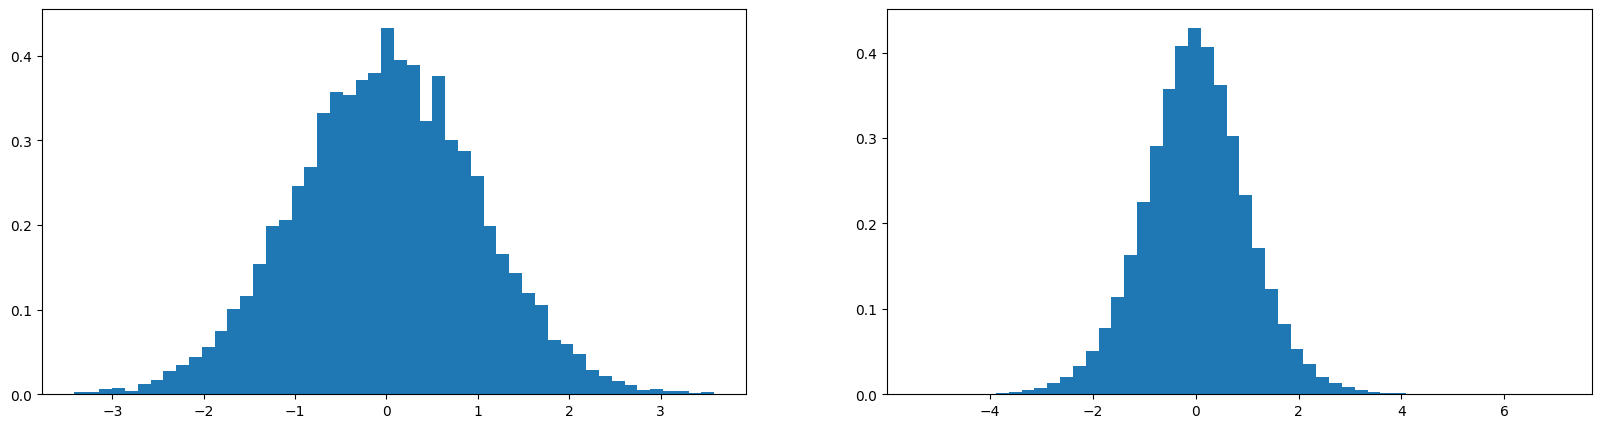

In [46]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [47]:
(torch.randn(10000) * 0.2).std()

tensor(0.2019)

In [48]:
(5/3) / (30**0.5)

0.3042903097250923

In [50]:
#Optimization

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    #Forward Pass
    emb = C[Xb] #embed chars to vectors
    embcat = emb.view(emb.shape[0], -1) # concatanate the vectors
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #Loss Function
    # print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    #track Stat
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d} / {max_steps : 7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break 

      0 /  100000 3.3174
  10000 /  100000 2.1913
  20000 /  100000 2.3277
  30000 /  100000 2.5396
  40000 /  100000 1.9471
  50000 /  100000 2.3337
  60000 /  100000 2.3915
  70000 /  100000 2.0306
  80000 /  100000 2.1982
  90000 /  100000 2.0677


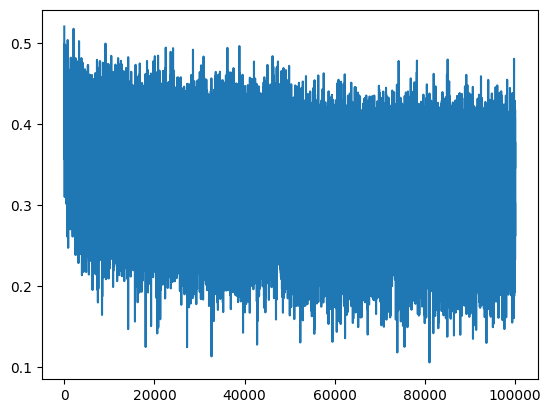

In [51]:
plt.plot(lossi)

In [52]:
@torch.no_grad()    # this decorator desables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, num_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)    
    print(loss.item())

split_loss('train')
split_loss('val')

# ver 2 
# 2.2141671180725098
# 2.262075424194336

#Ver3
# 2.0615365505218506
# 2.1102068424224854


2.0621516704559326
2.113983392715454


In [15]:
#Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initalizing with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

eria.
kena.
zee.
ren.
heyah.
remyrs.
ejd.
leg.
azer.
dee.
iuz.
myloe.
reigh.
eso.
nar.
ell.
kolly.
ami.
sher.
roshi.
